### Import Libraries

In [2]:
! pip install pandas
! pip install numpy
! pip install scikit-learn
! pip install matplotlib
! pip install seaborn
! pip install streamlit

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

### Load and Explore data

In [4]:
leads_df = pd.read_csv('sample_leads.csv') 
print(leads_df.head())


  company_name    industry       location  employee_count revenue_estimate  \
0     NexaTech        SaaS  San Francisco              80               5M   
1     MediLink  HealthTech       New York             200              12M   
2     EduSpark      EdTech      Bengaluru              45             1.2M   
3     Finverse     FinTech         London             150              10M   
4    CleanVolt   GreenTech         Berlin              30             800K   

  growth_source                 website                      description  \
0        GrowJo         www.nexatech.io          AI-powered CRM for SMBs   
1        Apollo  www.medilinkhealth.com        Patient tracking software   
2        Manual         www.eduspark.co            Online learning tools   
3        GrowJo         www.finverse.co  Real-time transaction analytics   
4        Manual       www.cleanvolt.org    Solar panel optimization tech   

  funding_stage  
0      Series A  
1      Series B  
2          Seed  
3 

In [5]:
print(leads_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   company_name      31 non-null     object
 1   industry          31 non-null     object
 2   location          31 non-null     object
 3   employee_count    31 non-null     int64 
 4   revenue_estimate  31 non-null     object
 5   growth_source     31 non-null     object
 6   website           31 non-null     object
 7   description       31 non-null     object
 8   funding_stage     31 non-null     object
dtypes: int64(1), object(8)
memory usage: 2.3+ KB
None


In [6]:

print(leads_df.describe())

       employee_count
count       31.000000
mean       103.064516
std         67.720964
min         20.000000
25%         57.500000
50%         90.000000
75%        140.000000
max        300.000000


### Data Preprocessing

In [ ]:
# Identify numerical and categorical columns
numerical_cols = leads_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = leads_df.select_dtypes(include='object').columns.tolist()

# Handle potential ID columns (remove or exclude from features)
id_cols = [col for col in leads_df.columns if 'ID' in col]  
numerical_cols = [col for col in numerical_cols if col not in id_cols] # Exclude IDs from numerical features
categorical_cols = [col for col in categorical_cols if col not in id_cols] # Exclude IDs from categorical features

# Create a preprocessor to handle both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categoricals
    ])

# Fit and transform the data
processed_data = preprocessor.fit_transform(leads_df)

# Convert to dense array if it's a sparse matrix (often happens with OneHotEncoder)
processed_data_dense = processed_data.toarray() if hasattr(processed_data, 'toarray') else processed_data

# Create a DataFrame from the processed data
processed_df = pd.DataFrame(processed_data_dense, columns=preprocessor.get_feature_names_out())
print(processed_df.head())



   num__employee_count  cat__company_name_AdviSmart  \
0            -0.346211                          0.0   
1             1.455057                          0.0   
2            -0.871581                          0.0   
3             0.704528                          0.0   
4            -1.096740                          0.0   

   cat__company_name_AutoOptima  cat__company_name_BioNext  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   

   cat__company_name_BrightNest  cat__company_name_CityDash  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0             

### Determine Optimal no. of clusters using elbow method

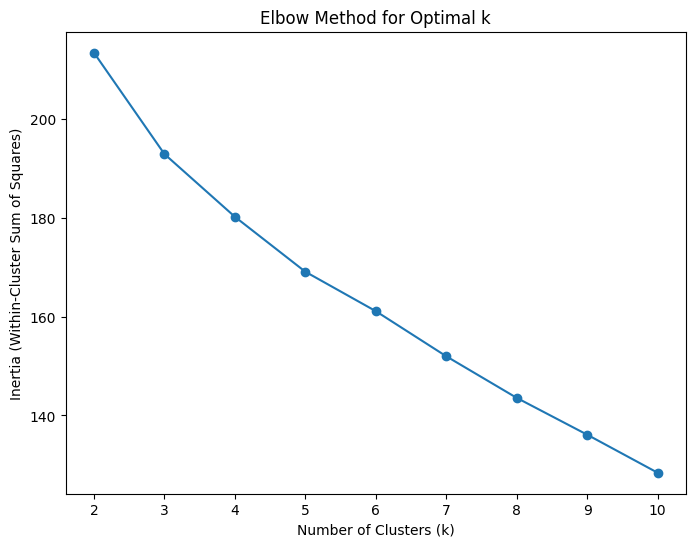

In [ ]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(2, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

###  Determine Optimal no. of clusters using silhoutte score

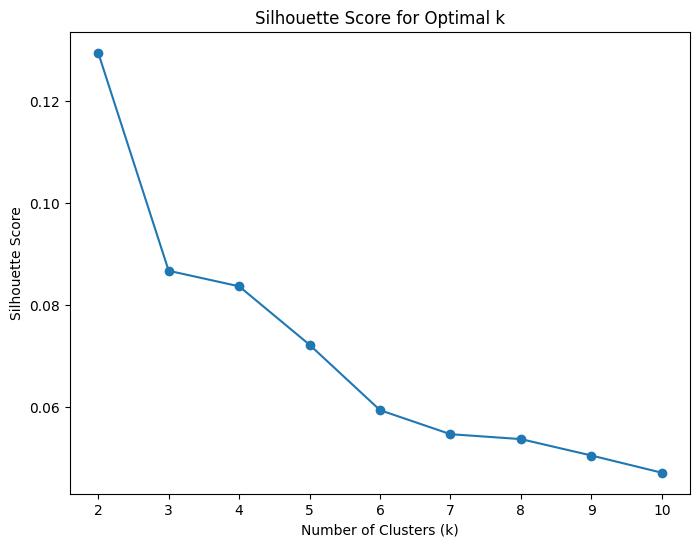

In [11]:
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(processed_data)
    silhouette_scores.append(silhouette_score(processed_data, kmeans.labels_))

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

### applying kmeans clustering

In [23]:
# Choose the optimal k from the Elbow Method and/or Silhouette Score
optimal_k = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
leads_df['Cluster'] = kmeans.fit_predict(processed_data)

print(leads_df[['Cluster']].head())
print(leads_df['Cluster'].value_counts())

   Cluster
0        2
1        0
2        1
3        2
4        1
Cluster
2    13
1    10
0     8
Name: count, dtype: int64


### Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA to reduce data to 2 components for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(processed_data)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = leads_df['Cluster'] 

print("PCA Explained Variance Ratio:")
print(pca.explained_variance_ratio_) 
print(f"Total variance explained by 2 PCs: {pca.explained_variance_ratio_.sum():.2f}")

PCA Explained Variance Ratio:
[0.1753627  0.09051769]
Total variance explained by 2 PCs: 0.27


### Visualising the clusters

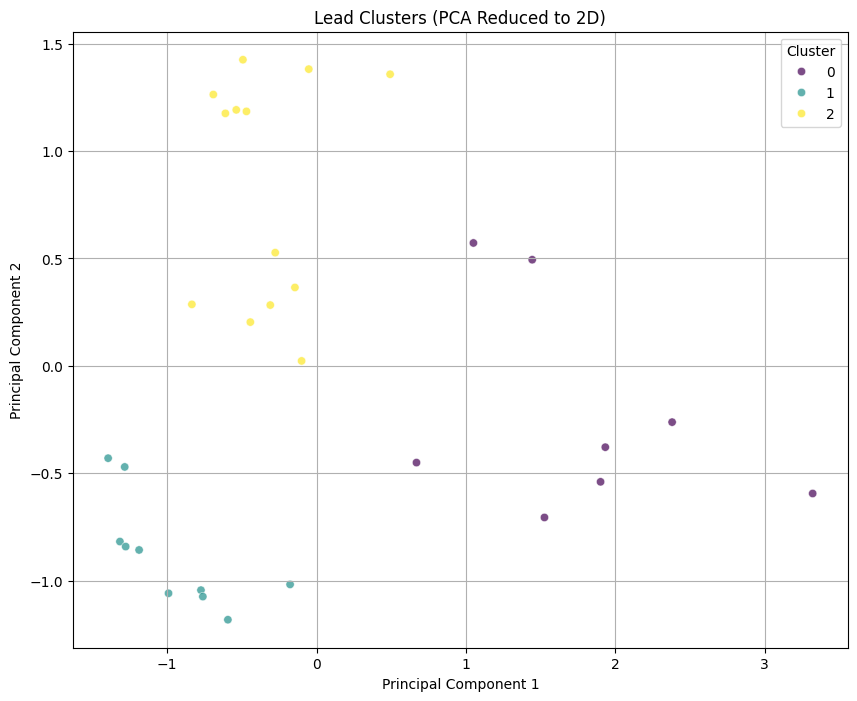

In [25]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis", # Or 'tab10', 'plasma', etc.
    data=pca_df,
    legend="full",
    alpha=0.7 # Add some transparency
)
plt.title('Lead Clusters (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

### Analyse the clusters

In [ ]:
# Analyze the characteristics of each cluster

# 1. Summarize Numerical Features (Mean)

if not numerical_cols: 
    numerical_cols_for_summary = leads_df.select_dtypes(include=np.number).columns.tolist()
    if 'Cluster' in numerical_cols_for_summary:
        numerical_cols_for_summary.remove('Cluster')
else:
    # Use the numerical_cols identified earlier, making sure they are in the current leads_df
    numerical_cols_for_summary = [col for col in numerical_cols if col in leads_df.columns]


print("--- Numerical Feature Summary per Cluster (Mean) ---")
cluster_summary_numerical = leads_df.groupby('Cluster')[numerical_cols_for_summary].mean()
print(cluster_summary_numerical)

# 2. Summarize Categorical Features (Value Counts / Percentages)

print("\n--- Categorical Feature Summary per Cluster (Value Counts/Percentages) ---")
for col in categorical_cols: 
    if col in leads_df.columns: 
        print(f"\nCluster Profiles for {col}:")
        # Use .unstack() to get a more readable table format for value counts
        print(leads_df.groupby('Cluster')[col].value_counts(normalize=True).unstack(fill_value=0))

# Based on this analysis, assign a priority to each cluster

cluster_priorities = {
    0: 'Hot',  # Adjust based on your analysis of cluster_summary_numerical and categorical profiles
    1: 'Warm',
    2: 'Cold',
    3: 'Warm' # Adjust 'optimal_k' value if different
}

leads_df['Priority'] = leads_df['Cluster'].map(cluster_priorities)
print("\nLeads with Assigned Priority (First 5 rows):")
print(leads_df[['Cluster', 'Priority']].head())

--- Numerical Feature Summary per Cluster (Mean) ---
         employee_count
Cluster                
0            197.500000
1             47.500000
2             87.692308

--- Categorical Feature Summary per Cluster (Value Counts/Percentages) ---

Cluster Profiles for company_name:
company_name  AdviSmart  AutoOptima  BioNext  BrightNest  CityDash  CivicEdge  \
Cluster                                                                         
0                 0.125       0.125      0.0         0.0     0.125        0.0   
1                 0.000       0.000      0.1         0.1     0.000        0.1   
2                 0.000       0.000      0.0         0.0     0.000        0.0   

company_name  CleanVolt  CodeSilo  CraftCloud  EduPilot  ...  PathFindr  \
Cluster                                                  ...              
0                   0.0  0.000000       0.125  0.000000  ...   0.000000   
1                   0.1  0.000000       0.000  0.000000  ...   0.000000   
2        

### Streamlit Integration

In [27]:
import joblib

# Define the paths to save your model and preprocessor
preprocessor_path = 'preprocessor.joblib'
kmeans_model_path = 'kmeans_model.joblib'
cluster_priorities_path = 'cluster_priorities.joblib' # Save your cluster-to-priority mapping

# Save the preprocessor
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to {preprocessor_path}")

# Save the KMeans model
joblib.dump(kmeans, kmeans_model_path)
print(f"KMeans model saved to {kmeans_model_path}")

# Save the cluster_priorities dictionary
joblib.dump(cluster_priorities, cluster_priorities_path)
print(f"Cluster priorities saved to {cluster_priorities_path}")

Preprocessor saved to preprocessor.joblib
KMeans model saved to kmeans_model.joblib
Cluster priorities saved to cluster_priorities.joblib
